In [148]:
import numpy as np
from scipy import linalg as lin
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

# Part 1

We have increased the depth from $101$ to $1001$ so we shall increase the indices where the peaks are as well. Indices in Python start from $0$ so index $50$ in Matlab becomes $49$ in Python and so forth.

In [233]:
M = 1001
zmin = 0.
zmax = 1e1
Dz = (zmax - zmin) / (M - 1e0)
z = zmin + Dz*np.arange(M)
mtrue = np.zeros(M)
mtrue[49] = 1.
mtrue[99] = 1.
mtrue[199] = 1.
mtrue[499] = 1.
mtrue[899] = 1.

In [234]:
N = M
cmin = 0.
cmax = 1e1
Dc = (cmax - cmin) / (N-1)
c = cmin + Dc*np.arange(N)
G = c[:, np.newaxis] * np.exp( - c[:, np.newaxis]*z)

sd = 1e-2
dtrue = np.dot(G, mtrue)
dobs = dtrue + np.random.normal( 0., sd , N )   # Noise: normal distribution with zero mean and 0.01 standard deviation

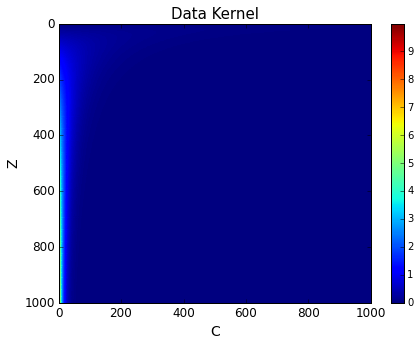

In [235]:
x = np.arange(M)
y = np.arange(N)

fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ca = ax.pcolormesh(x, y, G)
cbar = fig.colorbar(ca)
ax.set_title(r'Data Kernel', fontsize=15)
ax.set_xlabel(r'C', fontsize=14)
ax.set_ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

In [236]:
print (G*Dz).sum(axis=1)

[ 0.          0.09525782  0.18145112 ...,  1.05072987  1.05078153
  1.05083319]


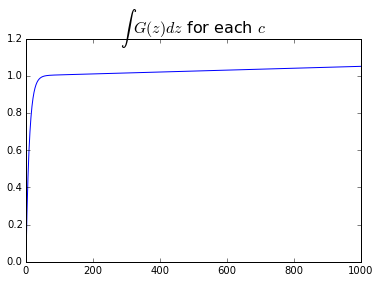

In [237]:
plt.figure()
plt.plot((G*Dz).sum(axis=1))
plt.title(r'$\int \ G(z) dz$ for each $c$', fontsize=16)

We see above that the normalization of G is approximately satisfied, i.e. 

$$\int G(z) \ dz \simeq 1$$

# Part 2

The Python algorithm for singular value decomposition gives

$$U, L, V^T = svd(G)$$

In [238]:
U, L, V = lin.svd(G)

print U.shape, L.shape, V.shape

(1001, 1001) (1001,) (1001, 1001)


(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 7 Text yticklabel objects>)

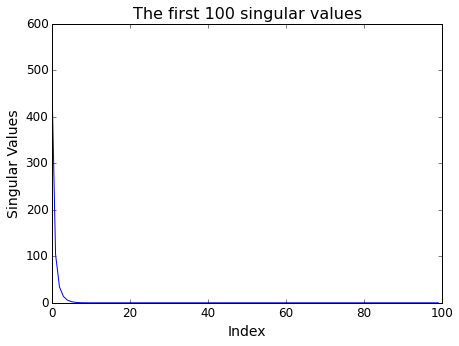

In [253]:
fig = plt.figure(figsize=(7,5))

ax = plt.gca()
ax.plot(L[:100])
ax.set_title('The first 100 singular values', fontsize=16)
ax.set_xlabel(r'Index', fontsize=14)
ax.set_ylabel(r'Singular Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

The figure above plots the first 100 singular values and we shall choose $p$ as $7$. The natural solution is derived as

$$\boldsymbol{m}^{est} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T \boldsymbol{d}^{obs}$$

In [241]:
p = 7
Up = U[:, :p].copy()
Vp = V.T[:, :p].copy()
Lp = L[:p].copy()
# Lambdap1 = 1./Lp
# print Lambdap1.shape

In [242]:
# mest_Nat = np.dot(np.dot( np.dot( Vp, Lambdap1 ), Up.T), dobs )
mest_Nat = np.dot( Vp, np.dot(Up.T, dobs) / Lp ) 
print mest_Nat.shape

(1001,)


The model-parameter estimates for damped least square is

$$\boldsymbol{m}^{est} = \big[ \boldsymbol{G}^T \boldsymbol{G} + \epsilon^2 \boldsymbol{I} \big]^{-1} \boldsymbol{G}^T \boldsymbol{d}^{obs} $$

In [243]:
eps = 1e-2
mest_DLS = np.dot( np.dot( lin.inv( np.dot(G.T, G) + eps**2*np.identity(M) ), G.T ), dobs )

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

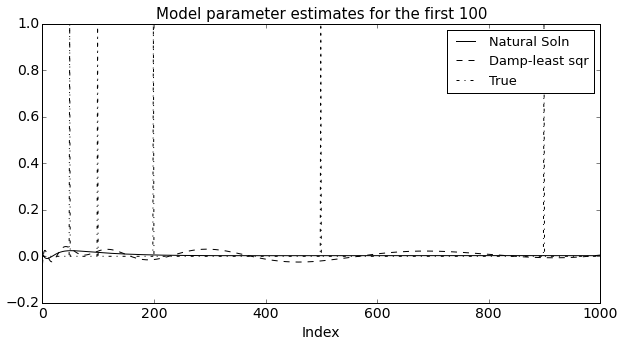

In [244]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln')
ax.plot(mest_DLS, 'k--', label=r'Damp-least sqr')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates for the first 100', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Comments

Since there are a lot of zero values, the amplitude of the estimated model parameters become small. The damped least square solution has negative values, which is an undesirable feature since the true model parameters are all non-negative. Except for the first peak in the true model parameters which the natural solution predicts correctly, neither of the estimated model parameters get the location of the true peaks exactly. It is interesting the natural solution is almost flat below the depth of 300. We could try to incorporate the effects of the peaks at deeper depths in the natural solution by increasing $p$ but this would also result in more sidelobes.

The model resolution matrix and unit covariance matrix are

$$ \boldsymbol{R} = \boldsymbol{G}^{-g} \boldsymbol{G} = \boldsymbol{V}_P \boldsymbol{V}_P^T $$

$$ \boldsymbol{N} = \boldsymbol{G} \boldsymbol{G}^{-g} = \boldsymbol{U}_P \boldsymbol{U}_P^T $$

$$ cov_u( \boldsymbol{m}^{est} ) = {\sigma_d}^{-2} \boldsymbol{G}^{-g} cov( \boldsymbol{d}^{obs} ) {\boldsymbol{G}^{-g}}^T = \boldsymbol{G}^{-g} {\boldsymbol{G}^{-g}}^T $$

where $\boldsymbol{G}^{-g} = \boldsymbol{V}_P \boldsymbol{\Lambda}_P^{-1} \boldsymbol{U}_P^T $.

In [245]:
print Up.shape, Vp.shape, Lp.shape

(1001, 7) (1001, 7) (7,)


In [246]:
Lambdap1 = Lp * np.identity(p)
print Lambdap1

R = np.dot(Vp, Vp.T)
DatRes = np.dot(Up, Up.T)
Gg = np.dot( np.dot( Vp, lin.inv(Lambdap1) ), Up.T )
cov_m = np.dot( Gg, Gg.T )

[[ 505.06485409    0.            0.            0.            0.            0.
     0.        ]
 [   0.          104.14128147    0.            0.            0.            0.
     0.        ]
 [   0.            0.           34.29939068    0.            0.            0.
     0.        ]
 [   0.            0.            0.           13.78768019    0.            0.
     0.        ]
 [   0.            0.            0.            0.            6.01915277
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     2.57409846    0.        ]
 [   0.            0.            0.            0.            0.            0.
     1.02819187]]


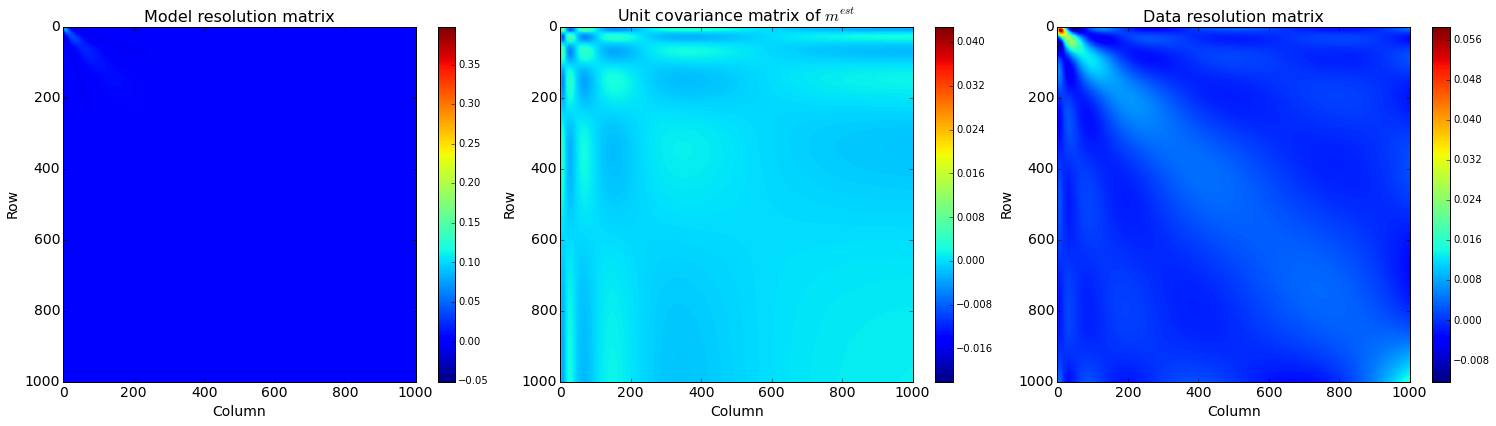

In [247]:
x = np.arange(M)
y = x.copy()

fig = plt.figure(figsize=(21,6))

ax1 = fig.add_subplot(131)
ca1 = ax1.pcolormesh(x, y, R)
cbar = fig.colorbar(ca1)
ax1.set_title(r'Model resolution matrix', fontsize=16)
ax1.set_xlabel(r'Column', fontsize=14)
ax1.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax2 = fig.add_subplot(132)
ca2 = ax2.pcolormesh(x, y, cov_m)
cbar = fig.colorbar(ca2)
ax2.set_title(r'Unit covariance matrix of $m^{est}$', fontsize=16)
ax2.set_xlabel(r'Column', fontsize=14)
ax2.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax3 = fig.add_subplot(133)
ca3 = ax3.pcolormesh(x, y, DatRes)
cbar = fig.colorbar(ca3)
ax3.set_title(r'Data resolution matrix', fontsize=16)
ax3.set_xlabel(r'Column', fontsize=14)
ax3.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()


The spread and size of matrix $\boldsymbol{R}$ and vector $\boldsymbol{m}$ is defined as

$$ spread(\boldsymbol{R}) = || \boldsymbol{R} - \boldsymbol{I} ||^2_2, \ \ \ \ size( cov_u( \boldsymbol{m}) ) = \big| \big| var_u( \boldsymbol{m} )^{1/2} \big| \big|_2^2 $$

In [248]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

994.0 1.1306428591


## Comments

The spread of the model resolution matrix is $994.0$ and the size of the unit covariance matrix of the estimated model parameters is $1.131$.

In [249]:
for p in range(101, -1, -1):

    Up = U[:, :p].copy()
    Vp = V.T[:, :p].copy()
    Lp = L[:p].copy()
    Lambdap1 = Lp * np.identity(p)
    
    mest_Nat = np.dot( Vp, np.dot(Up.T, dobs) / Lp ) 
    
    R = np.dot(Vp, Vp.T)
    DatRes = np.dot(Up, Up.T)
    Gg = np.dot( np.dot( Vp, lin.inv(Lambdap1) ), Up.T )
    cov_m = np.dot( Gg, Gg.T )
    
    spR = ( (R - np.identity(M))**2 ).sum()
    szm = ( np.diagonal(cov_m) ).sum()
    
    
    if all( i < 1 for i in np.diagonal(cov_m) ):
        print p
        break

8


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

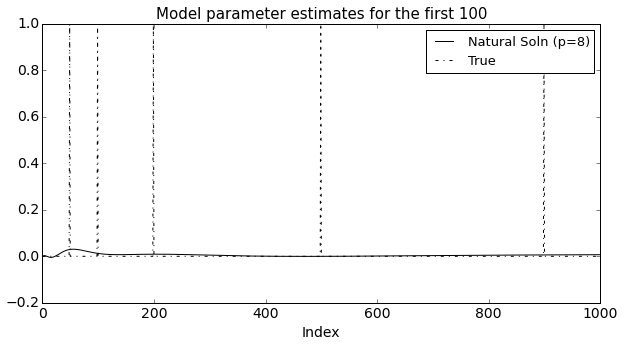

In [250]:
fig = plt.figure(figsize=(10,5))

ax = plt.gca()
ax.plot(mest_Nat, 'k', label=r'Natural Soln (p=8)')
ax.plot(mtrue, 'k-.', label=r'True')
ax.set_title(r'Model parameter estimates for the first 100', fontsize=15)
ax.set_xlabel(r'Index', fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

As $p$ grows larger, the noise increases as well due to smaller scale fluctuations in the estimated model parameters. Thus, we shall choose the largest $p$ which satisfies the condition of the diagonal elements of unit covariance matrix being less than unity for all depths. From the figure above, we see that the natural solution $\boldsymbol{m}^{est}_{NatSoln}$ gets the location of the first peak in $\boldsymbol{m}^{true}$ right but the smaller scale features are smudged out.

In [251]:
spR = ( (R - np.identity(M))**2 ).sum()
szm = ( np.diagonal(cov_m) ).sum()

print spR, szm

993.0 7.8903988283


## Comments

The spread of the model resolution matrix is $993.0$ and the size of the unit covariance matrix of the estimated model parameters is $7.890$. If the resolution were perfect, the model resolution matrix would end up as an identity matrix so the spread should be zero. We see that changing from $p=7$ to $p=8$ reduced the spread, meaning that $p=8$ has higher resolution.

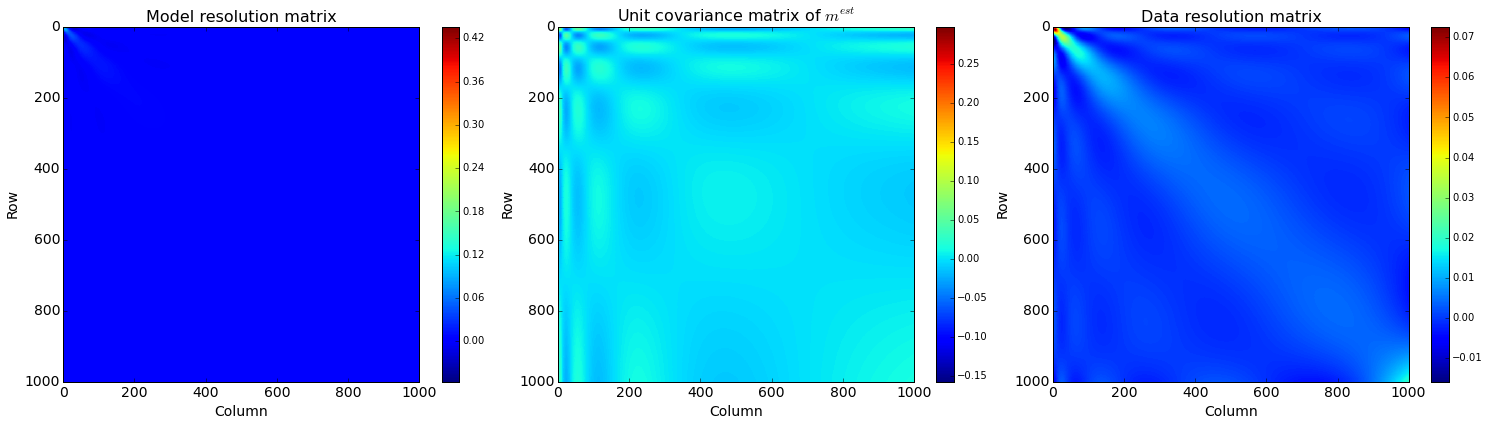

In [252]:
x = np.arange(M)
y = x.copy()

fig = plt.figure(figsize=(21,6))

ax1 = fig.add_subplot(131)
ca1 = ax1.pcolormesh(x, y, R)
cbar = fig.colorbar(ca1)
ax1.set_title(r'Model resolution matrix', fontsize=16)
ax1.set_xlabel(r'Column', fontsize=14)
ax1.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax2 = fig.add_subplot(132)
ca2 = ax2.pcolormesh(x, y, cov_m)
cbar = fig.colorbar(ca2)
ax2.set_title(r'Unit covariance matrix of $m^{est}$', fontsize=16)
ax2.set_xlabel(r'Column', fontsize=14)
ax2.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()

ax3 = fig.add_subplot(133)
ca3 = ax3.pcolormesh(x, y, DatRes)
cbar = fig.colorbar(ca3)
ax3.set_title(r'Data resolution matrix', fontsize=16)
ax3.set_xlabel(r'Column', fontsize=14)
ax3.set_ylabel(r'Row', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
